### Astrometric Exoplanet Characterization DRM ###

- What precision do we want masses? 1-sigma (~33%) precision? Is this to inform radius (and thus radius-albedo degeneracy?) or logg from spectral receivals? 
- What is the per-epoch precision?
- How many epochs needed to get 1-sigma (SNR=1) precision, for Earth twins around Sunlike stars, as a function of distance?
    - centroiding errors: 1e-5 pix 
    - astrophysical noise: starspot modulations 
    
    
### To do list: ###
1. Compute how many epochs necessary to measure Earth-mass as a function of distance (Marc email/figure?)
2. Compute exposure times as a function of magnitude
3. Compute settling times
4. Examine doing astrometry in conjunction with UV characterization (the "50 stars" list). Note that stellar monitoring needs short cadence intense monitoring (flares) + long baseline monitoring (starspot cycles), how to distribute??

https://arxiv.org/pdf/1803.04642.pdf (value of astrometry)

https://arxiv.org/pdf/1804.00699.pdf 

https://arxiv.org/pdf/1411.1173.pdf

In [1]:
# import pythonic universe
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astropy.table import Table, vstack


import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pylab as plt
%matplotlib inline

# some global constants
TWOPI = 2*np.pi


# make readable plots
def user_rc(lw=1.5, fontsize=10):
    """Set plotting RC parameters"""
    # These are the "Tableau 20" colors as RGB.
    """
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
    for i in range(len(tableau20)):
        r, g, b = tableau20[i]
        tableau20[i] = (r / 255., g / 255., b / 255.)
    """
    plt.rc('lines', linewidth=lw)
    import matplotlib
    if matplotlib.__version__[0]=='2':
        from cycler import cycler
#        plt.rc('axes', prop_cycle=cycler(c=tableau20), lw=1, labelsize=18, titlesize=22)
        plt.rc('axes', lw=1, labelsize=18, titlesize=22)
    else:
#        plt.rc('axes', axes_cycle=tableau20, lw=1, labelsize=18, titlesize=22)
        plt.rc('axes', lw=1, labelsize=18, titlesize=22)
    plt.rc('font', size=14, weight='normal')
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=14)
    plt.rc('xtick.major', size=6, width=1)
#    plt.rc('axes', labelsize=18, titlesize=22)
    plt.rc('figure', titlesize=22, figsize=(8,10))
    return
user_rc()

# Overhead Times Calculation #

Overhead time should 1) slew time 2) setting time 3) calibration time, so far just #1

In [2]:
def get_angular_separation(ra1, dec1, ra2, dec2):
    """Compute the angular separation in radians between 2 objects given positions in degrees.
    
    Parameters
    ----------
    ra1: (float) right ascension of object 1 in degrees
    dec1: (float) declination of object 1 in degrees
    ra2: (float) right ascension of object 2 in degrees
    dec2: (float) declination of object 2 in degrees"""
    
    assert ra1>=0. and ra1<=TWOPI and ra2>=0. and ra2<=TWOPI, "RA must be in [0, 2pi]: {} {}".format(ra1, ra2)
    assert dec1>=-np.pi/2. and dec1<=np.pi/2. and dec2>=-np.pi/2. and dec2<=np.pi/2., "DEC must be in [-pi/2, pi/2]: {} {}".format(dec1, dec2)
    cosA = np.sin(dec1)*np.sin(dec2) + np.cos(dec1)*np.cos(dec2)*np.cos(ra1-ra2)
    return np.arccos(cosA)

# to compute the slew time need to know how the instrument will slew:
# take shortest path vs. along 1 axis then another...?

def get_slew_times(sep, vel=3.):
    """Return the slew time from 1 target to another.
    
    Parameters
    ----------
    sep : (float) angular separation in degrees
    
    Kwargs
    ------
    vel : (float) slew speed, default = 3 deg/min
    """
    return sep/3.

def get_settling_times():
    return


In [3]:
def read_simbad_table(obj_name, **kwargs):
    """Read in Astroquery results from Simbad given object name (str)
    
    Parameter
    ---------
    obj_name : (str or list of str) name(s) of object
    
    kwargs (optional)
    ------
    votfields : (list) list of votable field keywords, from http://simbad.u-strasbg.fr/Pages/guide/sim-fscript.htx
                default is ['sptype', 'fluxdata(V)', 'velocity', 'distance']
    """
    customSimbad = Simbad()
    votfields = kwargs.pop('votfields', ['sptype', 'fluxdata(V)', 'velocity', 'distance'])
#    customSimbad.add_votable_fields('sptype')
#    customSimbad.add_votable_fields('fluxdata(V)')
#    customSimbad.add_votable_fields('velocity')
#    customSimbad.add_votable_fields('distance')
    for vf in votfields:
        customSimbad.add_votable_fields(vf)
    if type(obj_name) is str:
        result_table = customSimbad.query_object(obj_name)
    else:
        result_table = customSimbad.query_objects(obj_name)
    return result_table

### Aside: Use randomly distributed positions in celestial sphere to compute slew times ###
Populate the celestial sphere with Nstars=5 random (uniform distributed) positions, then compute angular separations & slew times

In [4]:
def populate_celestial_sphere(Nstars):
    """Populate positions randomly and uniformly distributed on a sphere.
    
    Parameters
    ----------
    Nstars : (int) number of points to generate
    
    From http://mathworld.wolfram.com/SpherePointPicking.html"""
    
    theta = np.random.uniform(low=0, high=2*np.pi, size=Nstars)
    z = np.random.uniform(low=-1, high=1, size=Nstars)
    x = np.sqrt(1.-z**2) * np.cos(theta)
    y = np.sqrt(1.-z**2) * np.sin(theta)
    return x, y, z

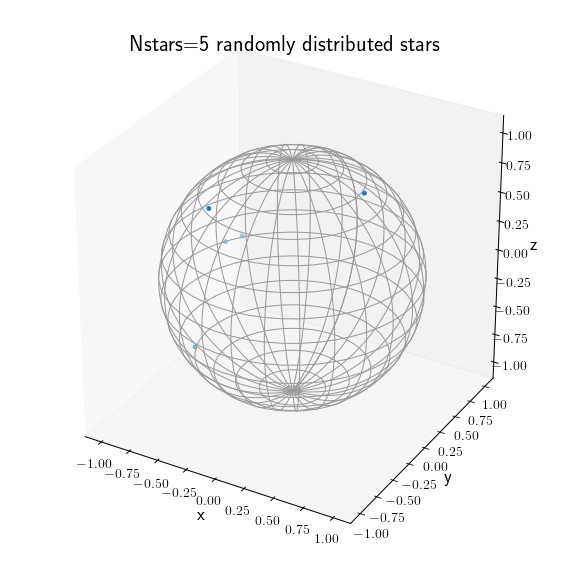

In [5]:
Nstars=5
x, y, z = populate_celestial_sphere(Nstars)


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))

u = np.linspace(0, np.pi, 50)
v = np.linspace(0, 2 * np.pi, 50)

x0 = np.outer(np.sin(u), np.sin(v))
y0 = np.outer(np.sin(u), np.cos(v))
z0 = np.outer(np.cos(u), np.ones_like(v))


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(x0, y0, z0, rstride=3, cstride=2, color='0.6', lw=1)

ax.scatter(x, y, z, s=15)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title("Nstars={} randomly distributed stars".format(Nstars))
plt.show()

In [6]:
c2 = SkyCoord(x, y, z, representation='cartesian')
xlon, xlat = c2.represent_as('spherical').lon.value, c2.represent_as('spherical').lat.value
#get_angular_separation(xlon[0], xlat[0], xlon[1], xlat[1])

angular_separations2 = []
for ii in range(Nstars-1):
    angsep = get_angular_separation(xlon[ii], xlat[ii], xlon[ii+1], xlat[ii+1]) * 180/np.pi
    angular_separations2.append(angsep)
    print("Ang sep [deg] btw. {} and {} = {:.2f}, slewing time [min] = {:.2f}".format(
            ii, ii+1, angsep, angsep/3.))
    
print("""==================================================================
      Total slew time [min] = {:.2f}""".format(np.array(angular_separations2).sum()/3.))

Ang sep [deg] btw. 0 and 1 = 143.50, slewing time [min] = 47.83
Ang sep [deg] btw. 1 and 2 = 92.74, slewing time [min] = 30.91
Ang sep [deg] btw. 2 and 3 = 127.29, slewing time [min] = 42.43
Ang sep [deg] btw. 3 and 4 = 122.99, slewing time [min] = 41.00
      Total slew time [min] = 162.17


In [31]:
print(get_tot_angular_sep(np.arange(xlon.shape[0]), xlon, xlat, closed=False) * 180/np.pi / 3.)

162.1749465934657


# Science Times #

Now, compute the actual science time needed to measure masses of habitable zone Earth candidates. This includes exposure time per epoch & how many epochs needed to measure mass to 1$\sigma$

In [ ]:
# fn to compute the astrometric (proper motion + parallax) signal given a set of parameters

# fn to parse the set of parameters for fiducial targets

# fn to compute the integration time/epochs needed for astrometric signal

# fn to compute slew time

# fn to minimize slew time

In [6]:
def get_telescope_architecture(arch='A', t_A=10., t_B=100.):
    """Returns telescope diameter, effective area, 
    and exposure times (according to Mark Postman)"""
    if arch == 'A' or arch == 'a':
        return 15., 175., t_A#300.
    else:
        return 8., 50., t_B#1200.

def get_astrometric_amplitude(mp, ms, period, d):
    """Computes astrometric signal in micro-arcsec given planet & 
    stellar mass, period, and distance
    
    Parameters
    ----------
    mp : (float) mass of pladef getnet in Earth mass
    ms : (float) mass of host star in stellar mass
    period : (float) period of system in yr
    d : (float) distance of system in pc
    """
    return 3.* mp * ms**(-2./3) * period ** (2./3) / d

def get_photon_flux(mag, magsun=-26.74, fsun=3.8e21):
    """Computes the photon flux in photons per sec per square meters given apparent magnitude
    
    Parameters
    ----------
    mag : (float) apparent magnitude of object
    
    Optional
    --------
    magsun : (float) apparent magnitude of the sun (reference star)
    fsun : (float) photon flux of the sun (reference star)"""
    
    return fsun * 10**((mag-magsun)/-2.5)

def get_F0_AB(lam):
    """Returns flux in photons per sec per m^2 per Angstrom for 
    0th magnitude star in AB system
    
    Parameters
    ----------
    lam : (float) wavelength of bandpass in Angstrom
    
    From: https://github.com/tumlinson/luvoir_simtools/blob/master/hdi_etc/SNR_equation.pdf
    """
    return 5.5099e11/lam

def get_apparent_mag(d, abs_mag):
    """Computes apparent magnitude using distance modulus
    
    Parameters
    ----------
    d : (float) distance in parsecs
    abs_mag : (float) absolute magnitude of the object"""
    return 5.*np.log(d/10.) + abs_mag

def get_equivalent_flux(mag_star, F0=1., A_tel=175., qe=0.8):
    """Computes the equivalent flux in photons per sec (for astrometric accuracy)
    
    Parameters
    ----------
    mag_star : (float) magnitude of target star
    
    Optional
    --------
    F0 : (float) flux from 0th magnitude star in photons per sec
    A_tel : (float) total collecting area of telescope in m^2
    qe : (float) quantum efficiency of detector
    """
    return F0 * 10**(-.4*mag_star) * qe * A_tel
    
    
def get_astrometric_precision(Fequiv, t_exp, Nobs=1, lam=5500., d_tel=15.):
    """Computes the astrometric accuracy in arcseconds PER epoch
    
    Parameters
    ----------
    Fequiv : (float) equivalent flux in photos per sec
    t_exp : (float) time of exposure in sec
    
    Optional
    ------
    Nobs : (int) number of observations
    lam : (float) wavelength of observation in angstrom
    d_tel : (float) diameter of telescope in m
    """
    return 206264.806 * lam*1e-10 / (2.*d_tel) / np.sqrt(Nobs * t_exp * Fequiv)

def get_exposure_time(sigma_obs, Fequiv, Nobs=1, lam=5500., d_tel=15.):
    """Computes the exposure time necessary to achieve given astrometric precision"""
    return (lam*1e-10 * 206264.806 / (2*d_tel*sigma_obs))**2 / Nobs / Fequiv

def get_pm_error_old(sigma, Nepochs=2., dt=0.5):
    """Computes proper motion systematic error in arcseconds / yr
    
    Parameters
    ----------
    sigma : (float) astrometric accuracy in arcsecond
    
    Optional
    --------
    Nepochs : number of epochs (default=2)
    dt : (float) time btw. separate epochs in yr (default=0.5 yr)
    """
    return (sigma * np.sqrt(2.) / dt) / np.sqrt(Nepochs-1.)

def get_pm_error(sigma, Nepochs=2., t_tot=2.):
    """Computes proper motion error in arcseconds / yr
    
    Parameters
    ----------
    sigma : (float) single-epoch astrometric accuracy
    
    Optional
    --------
    Nepochs : (float) number of epochs (default=2)
    t_tot : (float) total duration time (yr)
    """

    t = np.arange(0, t_tot, t_tot/Nepochs)
    return np.sqrt(Nepochs/sigma**2 / (Nepochs/sigma**2 * np.sum(t**2/sigma**2) - np.sum(t/sigma**2)**2))


def get_stellar_jitter_astrometric(d, inc=np.pi/2., p=24.47, jitter_rv_sun=0.38, f=1.0):
    """Returns the astrometric stellar jitter in uas
    
    Parameters
    ----------
    d : (float) distance to target in pc
    
    Optional
    --------
    inc : (float) inclination of system in radians (pi/2 = 90 deg = edge-on)
    p : (float) rotation period of star in d (solar value ~ 24.47 d)
    jitter_rv_sun : (float) the RV jitter of sun in m/s due to spots (default=0.38m/s)
    f : (float) scaling factor"""
    
    return f * jitter_rv_sun / (0.43*np.sin(inc) * d * 24.47 / p)

        
#def get_Nepochs(wobble, sigma, sigma dt=0.5):
#    return (wobble * dt / (206264.8 * sigma))**2

In [7]:
# Habitable zone calculations from Jake's notebook based on Kopparapu et al. (2013)
def calc_seff(Teff, S0, coeffs):
    a, b, c, d = coeffs
    T = Teff - 5780.
    return S0 + a*T + b*T**2 + c*T**3 + d*T**4

def calc_dist(L, Seff):
    return (L / Seff)**0.5

# Using the moist greenhouse inner edge
S0_inner = 1.0140
inner_edge = [8.1774e-5, 1.7063e-9, -4.3241e-12, -6.6462e-16]

# Using the maximum greenhouse outer edge
S0_outer = 0.3438
outer_edge = [5.8942e-5, 1.6558e-9, -3.0045e-12, -5.2983e-16]


def match_stellar_type(s, verbose = True):
    """
    Match stellar type ``s`` with the table of stellar types and return the index in table 
    that matches
    """
    for i, st in enumerate(stypes):
        if s == st:
            return i
    if verbose: print("No exact match found")
    for i, st in enumerate(stypes):
        if s.startswith(st):
            if verbose: print("Using %s for %s" %(st, s))
            return i
    for i, st in enumerate(stypes):
        if s.endswith(st):
            if verbose: print("Using %s for %s" %(st, s))
            return i
    for i, st in enumerate(stypes):
        if s+"V" == st:
            if verbose: print("Using %s for %s" %(st, s))
            return i
        
## 2-opt solution to Traveling Salesman Problem
def get_tot_dist(routes, cities, closed=True):
    """Computes the sum of Euclidean distances in array/matrix"""
    if closed:
        return np.sum([np.linalg.norm(cities[routes[i]] - cities[routes[i-1]]) for i in range(len(routes))])
    else:
        return np.sum([np.linalg.norm(cities[routes[i+1]] - cities[routes[i]]) for i in range(len(routes)-1)])

def get_tot_angular_sep(routes, ra, dec, closed=True): 
    if closed:
        return np.sum([np.arccos(np.sin(dec[routes[i]])*np.sin(dec[routes[i-1]]) + \
                         np.cos(dec[routes[i]])*np.cos(dec[routes[i-1]])*np.cos(ra[routes[i]]-ra[routes[i-1]])) for i in range(len(routes))])
    else:
        return np.sum([np.arccos(np.sin(dec[routes[i+1]])*np.sin(dec[routes[i]]) + \
                         np.cos(dec[routes[i+1]])*np.cos(dec[routes[i]])*np.cos(ra[routes[i+1]]-ra[routes[i]])) for i in range(len(routes)-1)])
    
def two_opt_swap(routes, i, k):
    """Propose new route based on 2opt-swap algorithm (Croes 1958)"""
    new_route = np.concatenate((routes[0:i], routes[i:k+1][::-1], routes[k+1:len(routes)]))
    return new_route

import itertools
def two_opt(cities, tol=1e-6, max_iter=1e4, closed=True):
    """Computes 2opt swap route given coordinates to cities[Ncities,Ncoords]"""
    # initialize route
    routes = np.arange(cities.shape[0])
    dist = get_tot_dist(routes, cities, closed=closed)
#     print(routes, dist)
    f = 1
    niter=0
    while f > tol and niter < max_iter:
        best_dist = dist
        for beg in range(1, len(routes)-2):
            for end in range(beg+1, len(routes)):
                new_routes = two_opt_swap(routes, beg, end)
                new_dist = get_tot_dist(new_routes, cities, closed=closed)
                if new_dist < dist:
#                     print(beg, end, new_routes, new_dist)
                    routes = new_routes
                    dist = new_dist
        f = 1. - dist/best_dist
        niter+=1
    return routes

def two_opt_stars(stars, tol=1e-6, max_iter=1e4, closed=True):
    """Computes 2opt swap route given coordinates to cities[Ncities,Ncoords]"""
    # initialize route
    ra, dec = stars
    routes = np.arange(ra.shape[0])
    dist = get_tot_angular_sep(routes, ra, dec, closed=closed)
#     print(routes, dist)
    f = 1
    niter=0
    while f > tol and niter < max_iter:
        best_dist = dist
        for beg in range(1, len(routes)-2):
            for end in range(beg+1, len(routes)):
                new_routes = two_opt_swap(routes, beg, end)
                new_dist = get_tot_angular_sep(new_routes, ra, dec, closed=closed)
                if new_dist < dist:
#                     print(beg, end, new_routes, new_dist)
                    routes = new_routes
                    dist = new_dist
        f = 1. - dist/best_dist
        niter+=1
    return routes

from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

# Distance callback
def create_distance_callback(dist_matrix):
  # Create a callback to calculate distances between cities.

  def distance_callback(from_node, to_node):
    return int(dist_matrix[from_node][to_node])

  return distance_callback

def get_best_route(city_names, dist_matrix):
  tsp_size = len(city_names)
  num_routes = 1
  depot = 0

  # Create routing model
  if tsp_size > 0:
    routing = pywrapcp.RoutingModel(tsp_size, num_routes, depot)
    search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
    # Create the distance callback.
    dist_callback = create_distance_callback(dist_matrix)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_callback)
    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)
    if assignment:
      # Solution distance.
      print "Total distance: " + str(assignment.ObjectiveValue()) + " miles\n"
      # Display the solution.
      # Only one route here; otherwise iterate from 0 to routing.vehicles() - 1
      route_number = 0
      index = routing.Start(route_number) # Index of the variable for the starting node.
      route = ''
      while not routing.IsEnd(index):
        # Convert variable indices to node indices in the displayed route.
        route += str(city_names[routing.IndexToNode(index)]) + ' -> '
        index = assignment.Value(routing.NextVar(index))
      route += str(city_names[routing.IndexToNode(index)])
      print "Route:\n\n" + route
    else:
      print 'No solution found.'
  else:
    print 'Specify an instance greater than 0.'
  return assignment.ObjectiveValue(), route

### Use N=5 real stars (w/ known positions) from Aki's biased draw of Chris' target list ###

Read in Simbad data and compute science and slew times given 5 unbiased draw from target list.

Note: in real mission scenario the observing strategy would be better optimized for closest neighbour, etc

Photon flux [phot m^-2 s^-1] of 0th magnitude star (Vega): 76521521494.8
55000000000.0 100180000.0
Arch A has d=15.0, A=175.0, t=10.0
127.85736653797252
Arch B has d=8.0, A=50.0, t=50.0
449.5486905942858
0.3


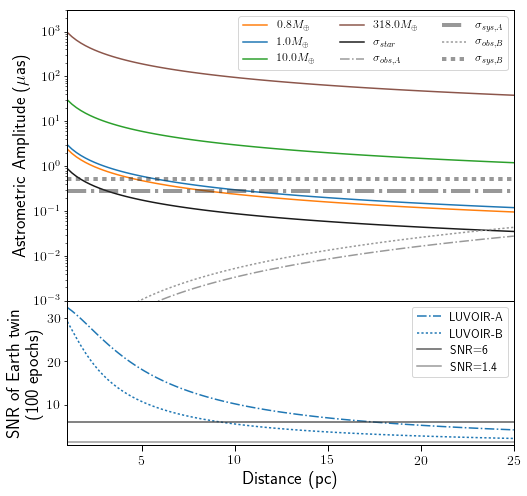

In [73]:
# Reproduce Mark Postman's plot for consistency check
from mpl_toolkits.axes_grid1 import make_axes_locatable

d_test = np.linspace(1, 25, 100) # distance array
apparent_mags = get_apparent_mag(d_test, abs_mag=4.83) #apparent magnitude of sunlike star at different distances

sys_error = dict({'A':0.28, 'B': 0.53}) #micro-arcseconds
F0 = get_photon_flux(0.) #get flux [phot m^-2 s^-1] of 0th magnitude star
#F0 = 1000*5500.*1e4 #phot m^-2 s^-1
#F0 = get_F0_AB(5500.)
print("Photon flux [phot m^-2 s^-1] of 0th magnitude star (Vega): {}".format(F0))
print("{} {}".format(1000*5500.*1e4, get_F0_AB(5500.)))

ms = 1.0
mp = np.array([0.8, 1.0, 10, 318])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("bottom", 2, pad=0.0, sharex=ax)
colors = ['C1', 'C0', 'C2', 'C5']
planet_labels = ['Venus twin', 'Earth twin', 'Super-Earth/Mini-Neptune', 'Jupiter twin']
for ii in range(len(mp)):
    ax.plot(d_test, get_astrometric_amplitude(mp[ii], ms, 1.0, d_test), #lw=4-ii, 
             label=r"${}M_{{\oplus}}$".format(mp[ii]), color=colors[ii])    
#             label=planet_labels[ii], color=colors[ii])  

stellar_errors = get_stellar_jitter_astrometric(d_test, inc=np.pi/2., 
                                                p=24.47, jitter_rv_sun=0.38, 
                                                f=1.0)
ax.plot(d_test, stellar_errors, color='0.1', label=r'$\sigma_{{star}}$')

earth_wobble_signal = get_astrometric_amplitude(1., ms, 1.0, d_test)
linestyles={'A': '-.', 'B': ':'}
for arch in ['A', 'B']:
#     dia, area, t_exp = get_telescope_architecture(arch, t_A=300., t_B=1200.)
    dia, area, t_exp = get_telescope_architecture(arch, t_A=10., t_B=50.)

    #t_exp/=10
    print("Arch {} has d={}, A={}, t={}".format(arch, dia, area, t_exp))
    f_equiv = get_equivalent_flux(apparent_mags, F0=F0, A_tel=area)
    sigmas = get_astrometric_precision(f_equiv, t_exp, d_tel=dia)
    pm_errors = np.array([get_pm_error(sigma, Nepochs=6., t_tot=2.0) for sigma in sigmas]) * 1e6

    #plt.plot(d_test, sigmas*180/np.pi * 3600.*1e6, '--', label='single-epoch uncertainty')
#    ax.plot(d_test, sigmas*1e6, color='purple', ls=linestyles[arch], label=r'$\sigma_{{obs, {}}}$'.format(arch))

#    ax.plot(d_test, pm_errors, color='0.7', ls=linestyles[arch], label=r'$\sigma_{{obs, {}}}$'.format(arch))
#    ax.axhline(sys_error[arch], color='0.3', ls=linestyles[arch], alpha=0.5, lw=6, label=r'$\sigma_{{sys, {}}}$'.format(arch))
#     if arch == 'A':
#         ax3 = ax.twiny()
#         exposure_times = get_exposure_time(earth_wobble_signal*1e-6, f_equiv, d_tel=dia)
#         ax3.plot(exposure_times, 0*exposure_times)
#         ax3.cla()
#         ax3.set_xlabel('Exposure Time (s)')
#         ax3.set_xscale('log')
    #plt.plot(d_interesting, pm_errors_interesting*1e6, 'o')
    tot_noise = np.sqrt((sigmas*1e6)**2 + sys_error[arch]**2 + stellar_errors**2)
    ax.plot(d_test, sigmas*1e6, color='0.6', ls=linestyles[arch], label=r'$\sigma_{{obs, {}}}$'.format(arch))
    ax.plot(d_test, sys_error[arch]+d_test*0., '0.2', alpha=0.5, lw=4, ls=linestyles[arch], label=r'$\sigma_{{sys, {}}}$'.format(arch))
#    ax.plot(d_test, tot_noise, 'y-')
    _epochs = (6.*tot_noise/earth_wobble_signal)**2
    print(_epochs[np.argmin(abs(d_test-19.9))])
    ax2.plot(d_test, earth_wobble_signal/(tot_noise/np.sqrt(100.)), color=colors[1], ls=linestyles[arch], label='LUVOIR-{}'.format(arch))
ax.set_yscale('log')
ax.set_ylabel('Astrometric Amplitude ($\mu$as)')
#ax.set_xlabel('Distance (pc)')
ax.set_xlim((d_test[0], d_test[-1]))
ax.set_ylim((0.001, 3000.))
ax.legend(fontsize=12, ncol=3)
plt.setp(ax.get_xticklabels(), visible=False)
ax2.axhline(6, color='0.2', label='SNR=6', alpha=0.8)
ax2.axhline(1.4, color='0.5', label='SNR=1.4', alpha=0.8)
ax2.set_ylabel('SNR of Earth twin\n(100 epochs)')
ax2.set_xlabel('Distance (pc)')
ax2.legend(fontsize=12)
plt.subplots_adjust(hspace=0.)
plt.savefig('signal_noise.png', dpi=100)
#ax2.set_yscale('log')
print(get_astrometric_amplitude(1.0, 1.0, 1.0, 10.))

In [77]:
# Set up number of universes we wish to observe, making Ndraw targets per universe
Ndraws = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
np.random.seed(1)

snr=3. #1-sigma? 3-sigma? measurement

Norbits_di = 6.

mean_science_times = np.zeros((len(Ndraws), 2))
std_science_times = mean_science_times*0.
mean_Nepochs = mean_science_times*0.
std_Nepochs = mean_science_times*0.
# mean_snr = mean_science_times*0.
# std_snr = mean_science_times*0.

## read in the biased draw from Aki and make 5 unbiased draws from them
obj_names_all = np.loadtxt('inputs/luvoir-A_stars.txt', usecols=(0,), delimiter=',', skiprows=1).astype(int)
stellar_types = np.loadtxt('inputs/luvoir-A_stars.txt', usecols=(2,), delimiter=',', dtype=str, skiprows=1)
stellar_distances = np.loadtxt('inputs/luvoir-A_stars.txt', usecols=(1,), delimiter=',', skiprows=1)


# Read in table of stellar types to match selected targets
data = np.loadtxt('inputs/stellar_properties.txt', skiprows=19, dtype = str)

stypes = data[:,0] 
masses = np.array(data[:,1], dtype=float)
lums = np.array(data[:,2], dtype=float)
rads = np.array(data[:,3], dtype=float)
temps = np.array(data[:,4], dtype=float)
mvs = np.array(data[:,6], dtype=float)

Nepochs0 = np.arange(2, 300, 0.1)
#print(blah)

In [130]:
# #limiting exposure times are 10s for mag=
# arch='B'
# dia, area, t_exp = get_telescope_architecture(arch, t_A=10., t_B=100.)
# print(dia, area, t_exp)

(8.0, 50.0, 100.0)


In [78]:
## make giant table of values for astrometric look up ##
result_all = read_simbad_table(np.core.defchararray.add("HIP", obj_names_all.astype(str)))

Nall = len(obj_names_all)
print(Nall)
mag_interesting = np.array(result_all['FLUX_V']) #V magnitude of targets
a_in = np.zeros(Nall)
a_out = a_in*0.0
a_eeq = a_in*0.0
stellar_masses = a_in*0.0
for ii in range(len(obj_names_all)):
    imatch = match_stellar_type(stellar_types[ii], verbose=True)
    stellar_masses[ii] = masses[imatch]
#    print("Matched with {}".format(stypes[imatch]))
    a_in[ii] = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
    a_out[ii] = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
#    print("HZ limits : %.2f - %.2f au" %(a_in[ii], a_out[ii]))
    a_eeq[ii] = np.sqrt(lums[imatch])

wobbles = get_astrometric_amplitude(mp[1], stellar_masses, a_eeq, stellar_distances)
stellar_errors = get_stellar_jitter_astrometric(stellar_distances, inc=np.pi/2., 
                                                p=24.47, jitter_rv_sun=0.38, f=1.0)

f_equiv_interesting = np.zeros((Nall, 2))
exposure_times = f_equiv_interesting*0.
sigmas_interesting = f_equiv_interesting*0.
tot_errors0 = f_equiv_interesting*0.
Nepochs = f_equiv_interesting*0.
# depends on telescope architecture
for i_arch, arch in enumerate(['A', 'B']):
    print(i_arch, arch)
    dia, area, t_exp = get_telescope_architecture(arch, t_A=10., t_B=100.)
    print(dia, area, t_exp)
    f_equiv_interesting[:,i_arch] = get_equivalent_flux(mag_interesting, F0=F0, A_tel=area)
    exposure_times[:,i_arch] = np.clip(get_exposure_time(wobbles*1e-6*0.1, 
                                                         f_equiv_interesting[:,i_arch], d_tel=dia), t_exp, t_exp*30.)
    sigmas_interesting[:,i_arch] = get_astrometric_precision(f_equiv_interesting[:,i_arch], 
                                                             exposure_times[:,i_arch], d_tel=dia)*1e6

    tot_errors0[:,i_arch] = np.sqrt(sigmas_interesting[:,i_arch]**2 + sys_error[arch]**2 + stellar_errors**2)
        
    Nepochs[:,i_arch] = np.array([Nepochs0[np.digitize(wobbles[jj], 
                                                       snr*tot_errors0[jj,i_arch]/np.sqrt(Nepochs0))] for jj in range(len(obj_names_all))])
    
outf = open("astrometry_output_AB.txt", "w")
outf2 = open("astrometry_output_stars.txt", "w")
outf.write("#HIP M_s d mag_v a_ein a_eout a_eeq wobble sigma_s Feq_A Feq_B texp_A texp_B sigma_obsA sigma_obsB Nepoch3_A Nepoch3_B\n")
outf2.write("#HIP Stype")
for jj in range(Nall):
    outf.write("{:6d} {:3.1f} {:8.5f} {:6.4f} {:6.4f} {:6.4f} {:6.4f} {:6.4f} {:6.4f} {:6.4e} {:6.4e} {:.1f} {:.1f} {:6.4f} {:6.4f} {:.2f} {:.2f} \n".format(obj_names_all[jj],
                                                                                        stellar_masses[jj],
                                                                                        stellar_distances[jj], mag_interesting[jj],
                                                                                        a_in[jj], a_out[jj], a_eeq[jj], 
                                                                                        wobbles[jj], 
                                                                                        stellar_errors[jj],
                                                                                        f_equiv_interesting[jj,0],
                                                                                        f_equiv_interesting[jj,1],
                                                                                        exposure_times[jj,0],
                                                                                        exposure_times[jj,1],
                                                                                        sigmas_interesting[jj,0],
                                                                                        sigmas_interesting[jj,1],
                                                                                        Nepochs[jj,0], Nepochs[jj,1]))
    outf2.write("{:6d} {:7s}\n".format(obj_names_all[jj], stellar_types[jj]))
outf.close()
outf2.close()

58
No exact match found
Using F3V for F3Vwvar
No exact match found
Using F5IV for F5IV-V
No exact match found
Using K5V for K5
No exact match found
Using G8V for G8Vp
No exact match found
Using K5V for K5
No exact match found
Using K4V for K4Vp
No exact match found
Using G8IV for G8IV-V
No exact match found
Using K5V for K5
No exact match found
Using G8V for G8Vvar
No exact match found
Using G5V for G3/G5V
No exact match found
Using F7IV for F7IV-V
No exact match found
Using G8IV for G8IVvar
(0, 'A')
(15.0, 175.0, 10.0)
(1, 'B')
(8.0, 50.0, 100.0)


In [37]:
hip, stellar_mass, stellar_distance, stellar_mag, a_in, a_out, a_eeq, wobble, sigma_star, feq_A, feq_B, texp_A, texp_B, sigma_obsA, sigma_obsB = np.loadtxt('astrometry_output_AB.txt', unpack=True)

In [74]:
snr=3.
Nepochs0 = np.arange(2, 1000, 0.1)
for eta, Ndraw in enumerate(Ndraws):
    Nuniverse = 500
    print("{}, Ndraw={}, Nuniverse={}".format(eta, Ndraw, Nuniverse))

    # Initialize the quantities we want to save (slew, science, times etc)
#    tot_times = np.zeros(Nuniverse)
    sci_times_A = np.zeros(Nuniverse)
    sci_times_B = np.zeros(Nuniverse)

    Nepochs_A = np.zeros((Nuniverse, Ndraw))
    Nepochs_B = np.zeros((Nuniverse, Ndraw))

#    tot_slew_times = np.zeros(Nuniverse)
#    SNratios = np.zeros((Nuniverse, Ndraw))

    for zz in range(Nuniverse):
        idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)
        ihip = hip[idraw]#np.random.choice(obj_names_all, size=Ndraw, replace=False)
        ia_eeq = a_eeq[idraw]
        istellar_mass = stellar_mass[idraw]
        istellar_distance = stellar_distance[idraw]

#         c = SkyCoord(result['RA'], result['DEC'], unit=(u.hourangle, u.deg))
#         slewroute = two_opt_stars((c.ra.radian, c.dec.radian), tol=0.001, closed=False)
#         tot_slew_times[zz] = get_tot_angular_sep(slewroute, c.ra.radian, c.dec.radian, closed=False) * 180./np.p

        # Calculate number of epochs needed per target
        istellar_mag = stellar_mag[idraw]
        iwobble = wobble[idraw]
        ifeq_A = feq_A[idraw]
        ifeq_B = feq_B[idraw]
        itexp_A = texp_A[idraw]
        itexp_B = texp_B[idraw]/2.
        isigma_obsA = sigma_obsA[idraw]
        isigma_obsB = sigma_obsB[idraw]
        isigma_star = sigma_star[idraw]
        tot_errors0_A = np.sqrt(isigma_obsA**2 + sys_error['A']**2 + isigma_star**2)
        tot_errors0_B = np.sqrt(isigma_obsB**2 + sys_error['B']**2 + isigma_star**2)

        Nepochs_A[zz,:] = np.array([Nepochs0[np.digitize(iwobble[jj], 
                                                       snr*tot_errors0_A[jj]/np.sqrt(Nepochs0))] for jj in range(len(isigma_obsA))])
        Nepochs_B[zz,:] = np.array([Nepochs0[np.digitize(iwobble[jj], 
                                                       snr*tot_errors0_B[jj]/np.sqrt(Nepochs0))] for jj in range(len(isigma_obsB))])
        sci_times_A[zz] = np.sum(Nepochs_A[zz,:]*itexp_A)/3600.
        sci_times_B[zz] = np.sum(Nepochs_B[zz,:]*itexp_B)/3600.
#         print("""----------------------------------------------------------------------
#         Tot. Science Time = {:.2f} hr for {} tot epochs over {} targets""".format(sci_times[zz], 
#                                                                      np.sum(Nepochs[zz,:]), Ndraw))
#         print("Best route {} yields total angular distance [deg] = {:.2f}".format(obj_names[slewroute], tot_slew_times[zz]))

    mean_science_times[eta, :] = np.nanmedian(sci_times_A), np.nanmedian(sci_times_B)
    std_science_times[eta, :] = np.nanstd(sci_times_A),np.nanstd(sci_times_B)
    mean_Nepochs[eta,:] = np.nanmedian(np.sum(Nepochs_A, axis=1)), np.nanmedian(np.sum(Nepochs_B, axis=1))
    std_Nepochs[eta,:] = np.nanstd(np.sum(Nepochs_A, axis=1)),np.nanstd(np.sum(Nepochs_B, axis=1))
#     mean_snr[eta] = np.nanmedian(np.sum(SNratios, axis=1))
#     std_snr[eta] = np.nanstd(np.sum(SNratios, axis=1))


0, Ndraw=5, Nuniverse=500
1, Ndraw=15, Nuniverse=500
2, Ndraw=25, Nuniverse=500
3, Ndraw=35, Nuniverse=500
4, Ndraw=45, Nuniverse=500
5, Ndraw=55, Nuniverse=500


In [30]:
# np.savez('sim_A.npz', Ndraws=Ndraws, mean_science_times=mean_science_times, 
#         std_science_times=std_science_times, mean_Nepochs=mean_Nepochs,
#        std_Nepochs=std_Nepochs, mean_snr=mean_snr, std_snr=std_snr)

test = np.load('sim_A.npz')

In [76]:
print(mean_science_times, std_science_times, mean_Nepochs, std_Nepochs)
#print(mean_science_times.shape, mean_science_times[:,1])
print(test['mean_science_times'])
#print(sci_times_A, sci_times_B, dNepochs_A, Nepochs_B)

(array([[ 0.19597222,  3.37430556],
       [ 0.58930556, 10.14236111],
       [ 0.98513889, 16.97013889],
       [ 1.38013889, 23.77847222],
       [ 1.77180556, 30.53055556],
       [ 2.16611111, 37.30486111]]), array([[0.04340442, 0.78135479],
       [0.06918246, 1.24665832],
       [0.07723138, 1.3918862 ],
       [0.077573  , 1.39718006],
       [0.06465893, 1.16498189],
       [0.03618551, 0.6516595 ]]), array([[  70.55,  242.95],
       [ 212.15,  730.25],
       [ 354.65, 1221.85],
       [ 496.85, 1712.05],
       [ 637.85, 2198.2 ],
       [ 779.8 , 2685.95]]), array([[ 15.6255925 ,  56.25754455],
       [ 24.90568552,  89.75939928],
       [ 27.80329736, 100.21580657],
       [ 27.9262795 , 100.59696431],
       [ 23.27721452,  83.87869615],
       [ 13.02678357,  46.91948387]]))
[ 6.80833333 20.2        34.1375     47.45416667 61.09444444 74.6375    ]


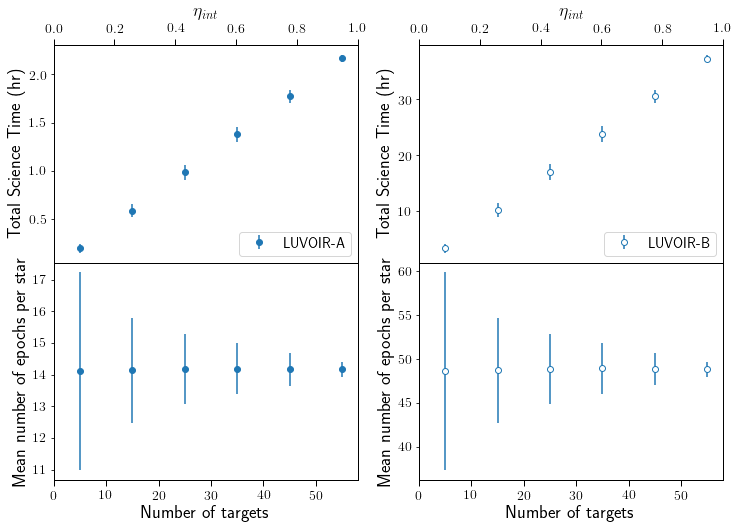

In [75]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
ax1.errorbar(Ndraws, mean_science_times[:,0], std_science_times[:,0], fmt='o', label='LUVOIR-A')
ax1.set_ylabel('Total Science Time (hr)')
ax1.legend(loc=4)
plt.setp(ax1.get_xticklabels(), visible=False)
#plt.errorbar(Ndraws, mean_science_times[:,1], std_science_times[:,1], fmt='v')
#plt.yscale('log')
ax2 = fig.add_subplot(223, sharex=ax1)
ax3 = ax1.twiny()
ax3.plot(Ndraws/float(len(obj_names_all)), mean_science_times[:,0])
ax3.cla()
ax3.set_xlim((0, 1))

ax3.set_xlabel('$\eta_{int}$')
ax2.errorbar(Ndraws, mean_Nepochs[:,0]/Ndraws, std_Nepochs[:,0]/Ndraws, fmt='o')
ax2.set_xlabel('Number of targets')
ax2.set_ylabel('Mean number of epochs per star')
ax2.set_xlim((0,len(obj_names_all)))

ax1b = fig.add_subplot(222)
ax1b.errorbar(Ndraws, mean_science_times[:,1], std_science_times[:,1], fmt='o', mfc='white', label='LUVOIR-B')
ax1b.legend(loc=4)
plt.setp(ax1b.get_xticklabels(), visible=False)
ax1b.set_ylabel('Total Science Time (hr)')
ax2b = fig.add_subplot(224, sharex=ax1b)
ax3b = ax1b.twiny()
ax3b.plot(Ndraws/float(len(obj_names_all)), mean_science_times[:,1])
ax3b.set_xlim((0, 1.))
ax3b.cla()
ax3b.set_xlabel('$\eta_{int}$')
ax2b.errorbar(Ndraws, mean_Nepochs[:,1]/Ndraws, std_Nepochs[:,1]/Ndraws, fmt='o', mfc='white')
ax2b.set_xlabel('Number of targets')
ax2b.set_ylabel('Mean number of epochs per star')
ax2b.set_xlim((0,len(obj_names_all)))
fig.subplots_adjust(hspace=0.)
plt.savefig("scitime_Nepoch.png", dpi=100)

In [ ]:
## OLD VERSION FOR BACK UP DON'T EDIT

# Set up number of universes we wish to observe, making Ndraw targets per universe
Ndraws = np.array([5, 15, 25, 35, 45, 55])
np.random.seed(1)

snr=3. #1-sigma? 3-sigma? measurement

arch='A'
Norbits_di = 6.

mean_times = []
std_times = []
mean_science_times = []
std_science_times = []
mean_Nepochs = []
std_Nepochs = []
mean_snr = []
std_snr = []

## read in the biased draw from Aki and make 5 unbiased draws from them
obj_names_all = np.loadtxt('inputs/luvoir-A_stars.txt', usecols=(0,), delimiter=',', skiprows=1).astype(int)
stellar_types = np.loadtxt('inputs/luvoir-A_stars.txt', usecols=(2,), delimiter=',', dtype=str, skiprows=1)
stellar_distances = np.loadtxt('inputs/luvoir-A_stars.txt', usecols=(1,), delimiter=',', skiprows=1)


# Read in table of stellar types to match selected targets
data = np.loadtxt('inputs/stellar_properties.txt', skiprows=19, dtype = str)

stypes = data[:,0] 
masses = np.array(data[:,1], dtype=float)
lums = np.array(data[:,2], dtype=float)
rads = np.array(data[:,3], dtype=float)
temps = np.array(data[:,4], dtype=float)
mvs = np.array(data[:,6], dtype=float)


dia, area, t_exp = get_telescope_architecture(arch)
Nepochs = np.arange(2, 300, 0.1)

for Ndraw in Ndraws[0:1]:
    print("Ndraw={}".format(Ndraw))
    Nuniverse = 500
#    Ndraw=5

    # Initialize the quantities we want to save (slew, science, times etc)
    tot_times = np.zeros(Nuniverse)
    tot_sci_times = np.zeros(Nuniverse)
    tot_Nepochs = np.zeros((Nuniverse, Ndraw))
    tot_slew_times = np.zeros(Nuniverse)
    wobbles = np.zeros((Nuniverse, Ndraw))
    SNratios = np.zeros((Nuniverse, Ndraw))

    for zz in range(Nuniverse):
        idraw = np.random.choice(np.arange(len(obj_names_all)), size=Ndraw, replace=False)
        obj_names = obj_names_all[idraw]#np.random.choice(obj_names_all, size=Ndraw, replace=False)

        ## stack each Simbad query results vertically in Astropy Table 
        obj_names = np.core.defchararray.add("HIP", obj_names.astype(str))
        result = read_simbad_table(obj_names)

        c = SkyCoord(result['RA'], result['DEC'], unit=(u.hourangle, u.deg))
#         angular_separations = np.zeros((Ndraw, Ndraw))
#         for ii in range(Ndraw):
#             for jj in range(Ndraw):
#                 if ii == jj:
#                     angsep = 0.
#                 else:
#                     angsep = get_angular_separation(c.ra[ii].radian, c.dec[ii].radian, 
#                                                 c.ra[jj].radian, c.dec[jj].radian) * 180/np.pi
#                 angular_separations[ii,jj] = angsep

#         tot_slew_times[zz], _ = get_best_route(obj_names, angular_separations)
        slewroute = two_opt_stars((c.ra.radian, c.dec.radian), tol=0.001, closed=False)
        tot_slew_times[zz] = get_tot_angular_sep(slewroute, c.ra.radian, c.dec.radian, closed=False) * 180./np.pi


        # Calculate the angular separations & slew times

#         ## convert the Simbad RA/DEC from hh.mm.ss to degrees
#         c = SkyCoord(result['RA'], result['DEC'], unit=(u.hourangle, u.deg))

#         for ii in range(len(obj_names)-1):
#             angsep = get_angular_separation(c.ra[ii].radian, c.dec[ii].radian, 
#                                             c.ra[ii+1].radian, c.dec[ii+1].radian) * 180/np.pi
#             angular_separations[zz,ii] = angsep
# #             print("Ang sep [deg] btw. {} and {} = {:.2f}, slewing time [min] = {:.2f}".format(
# #                     obj_names[ii], obj_names[ii+1], 
# #                     angsep, angsep/3.))
#         tot_slew_times[zz] = get_slew_times(np.array(angular_separations[zz,:]).sum())
# #         print("""==================================================================
# #               Total slew time [min] = {:.2f}""".format(tot_slew_times[zz]))


        # Calculate the HZ of targets

        a_in = np.zeros(Ndraw)
        a_out = a_in*0.0
        a_eeq = a_in*0.0
        stellar_masses = a_in*0.0
        #print(stellar_types)
        for ii in range(len(idraw)):
        #    print("{}, {}".format(obj_names[ii], stellar_types[idraw[ii]]))
            imatch = match_stellar_type(stellar_types[idraw[ii]], verbose=False)
            stellar_masses[ii] = masses[imatch]
        #    print("Matched with {}".format(stypes[imatch]))
            a_in[ii] = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
            a_out[ii] = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
        #    print("HZ limits : %.2f - %.2f au" %(a_in[ii], a_out[ii]))
            a_eeq[ii] = np.sqrt(lums[imatch])
        #    print("Earth-Equivalent Insolation Distance : %.2f au" %a_eeq[ii])


        # Calculate number of epochs needed per target
        mag_interesting = np.array(result['FLUX_V']) #V magnitude of targets
        wobbles[zz,:] = get_astrometric_amplitude(mp[1], stellar_masses, a_eeq, stellar_distances[idraw])

        f_equiv_interesting = get_equivalent_flux(mag_interesting, F0=F0, A_tel=area)
        exposure_times = np.clip(get_exposure_time(wobbles[zz,:]*1e-6*0.1, f_equiv_interesting, d_tel=dia), 10., t_exp)
        sigmas_interesting = get_astrometric_precision(f_equiv_interesting, exposure_times, d_tel=dia)

        #epochs_needed = mag_interesting*0.0

#         print("""{:6s} {:7s} {:4s} {:4s} {:6s} {:6s} {:7s} {:8s} {:8s} {:8s} {:8s}
# ----------------------------------------------------------------------------------------""".format('HIP','SpType',
#                                                                                                            'M',
#                                                                                                            'd',
#                                                                                                            'a_eq',
#                                                                                                            'wobble(uas)',
#                                                                                                            'N(SNR={})'.format(int(snr)),
#                                                                                                           'obs_err',
#                                                                                                           'sys_err', 
#                                                                                                        'stellar',
#                                                                                                       'tot_err'))
        
        for jj in range(len(sigmas_interesting)):
            pm_errors_interesting = np.array([get_pm_error(sigmas_interesting[jj], Nepochs=kk, t_tot=2.) for kk in Nepochs]) * 1e6
            sys_errors = sys_error[arch] #/ np.sqrt(Nepochs)
            obs_errors = sigmas_interesting[jj]*1e6 #/ np.sqrt(Nepochs)
            stellar_errors = get_stellar_jitter_astrometric(stellar_distances[idraw][jj], 
                                                            inc=np.pi/2., p=24.47, jitter_rv_sun=0.38, 
                                                            f=1.0)
            tot_errors = np.sqrt((obs_errors**2 + sys_errors**2 + stellar_errors**2)/Nepochs)
            
            e_ind = np.digitize(wobbles[zz,jj], snr*tot_errors, right=True)
            tot_Nepochs[zz,jj] = Nepochs[e_ind]
            SNratios[zz,jj] = wobbles[zz,jj] / np.sqrt((obs_errors**2 + sys_errors**2 + stellar_errors**2)/Norbits_di)
            
#             print("{:9s} {:4s} {:5.1f} {:6.2f} {:6.2f} {:7.4f} {:7.1f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}".format(obj_names[jj].replace('HIP', ''),
#                                                                                                                stellar_types[idraw][jj],
#                                                                                         stellar_masses[jj],
#                                                                                         stellar_distances[idraw][jj], 
#                                                                                         a_eeq[jj], 
#                                                                                         wobbles[zz,jj], 
#                                                                                         tot_Nepochs[zz,jj],
#                                                                                         obs_errors, 
#                                                                                         sys_errors, stellar_errors, 
#                                                                                                                tot_errors[e_ind]))



        # assuming 100s exposures per epoch, avg # of epochs needed, and total slew time per epoch,
        # the total telescope time needed is roughly (settling time not accounted for)
#         tot_times[zz] = np.nanmean(tot_Nepochs[zz,:]) * (t_exp/60.*Ndraw + tot_slew_times[zz]) / 60. 
        tot_sci_times[zz] = np.sum(tot_Nepochs[zz,:]*exposure_times)/60./60.
#         print("""----------------------------------------------------------------------------------------
#         Avg Nepochs = {:.2f}
#         Total Obs Time = Avg Nepochs x (tot slew per epoch + tot exp per epoch) 
#                         = {:.2f} hr""".format(np.nanmean(tot_Nepochs[zz,:]), tot_times[zz]))
        print("""----------------------------------------------------------------------------------------
        Total Science Time = {:.2f} hr for {} tot epochs""".format(tot_sci_times[zz], 
                                                                     np.sum(tot_Nepochs[zz,:])))
        print("Best route {} yields total angular distance [deg] = {:.2f}".format(obj_names[slewroute], tot_slew_times[zz]))

    mean_science_times.append(np.nanmedian(tot_sci_times))
    std_science_times.append(np.nanstd(tot_sci_times))
    mean_times.append(np.nanmedian(tot_slew_times/3.))
    std_times.append(np.nanstd(tot_slew_times/3.))
    mean_Nepochs.append(np.nanmedian(np.sum(tot_Nepochs, axis=1)))
    std_Nepochs.append(np.nanstd(np.sum(tot_Nepochs, axis=1)))
    mean_snr.append(np.nanmedian(np.sum(SNratios, axis=1)))
    std_snr.append(np.nanstd(np.sum(SNratios, axis=1)))
#     mean_times.append(np.nanmedian(tot_times))
#     std_times.append(np.nanstd(tot_times))


In [49]:
exposure_times

array([10., 10., 10., 10., 10.])

In [37]:
## convert the Simbad RA/DEC from hh.mm.ss to degrees
## this can be made more efficient by taking advantage of upper/lower triangle symmetry !!
print(obj_names)
result = read_simbad_table(obj_names)
#print(result['RA'], result['DEC'])
c = SkyCoord(result['RA'], result['DEC'], unit=(u.hourangle, u.deg))
angular_separations = np.zeros((Ndraw, Ndraw))
for ii in range(Ndraw):
    for jj in range(Ndraw):
        if ii == jj:
            angsep = 0.
        else:
            angsep = get_angular_separation(c.ra[ii].radian, c.dec[ii].radian, 
                                        c.ra[jj].radian, c.dec[jj].radian) * 180/np.pi # degrees
        angular_separations[ii,jj] = angsep

test_slew_time, _ = get_best_route(obj_names, angular_separations)
print(test_slew_time)
slewroute = two_opt_stars((c.ra.radian, c.dec.radian), tol=0.001, closed=True)
print(slewroute, obj_names[slewroute])
#plt.scatter(c.cartesian.x, c.cartesian.y)

#_as, _rt = get_best_route(obj_names, angular_separations)
#route = two_opt(, tol=0.001, closed=False)

#print(_as/3., _rt)

['HIP19335' 'HIP57757' 'HIP116085' 'HIP48113' 'HIP15371']
(<MaskedColumn name='RA' dtype='unicode13' unit='"h:m:s"' description=u'Right ascension' length=5>
04 08 36.6168
11 50 41.7182
23 31 22.2087
09 48 35.3713
03 18 12.8185, <MaskedColumn name='DEC' dtype='unicode13' unit='"d:m:s"' description=u'Declination' length=5>
+38 02 23.055
+01 45 52.991
+59 09 55.866
+46 01 15.633
-62 30 22.917)
Total distance: 379 miles

Route:

HIP19335 -> HIP116085 -> HIP48113 -> HIP57757 -> HIP15371 -> HIP19335
379
(array([0, 2, 3, 1, 4]), array(['HIP19335', 'HIP116085', 'HIP48113', 'HIP57757', 'HIP15371'],
      dtype='|S24'))


In [73]:
np.array(Ndraws[::2]).astype(float)/len(obj_names_all), mean_times

(array([0.0862069 , 0.25862069, 0.43103448, 0.60344828, 0.77586207]),
 array([90.73399917]))

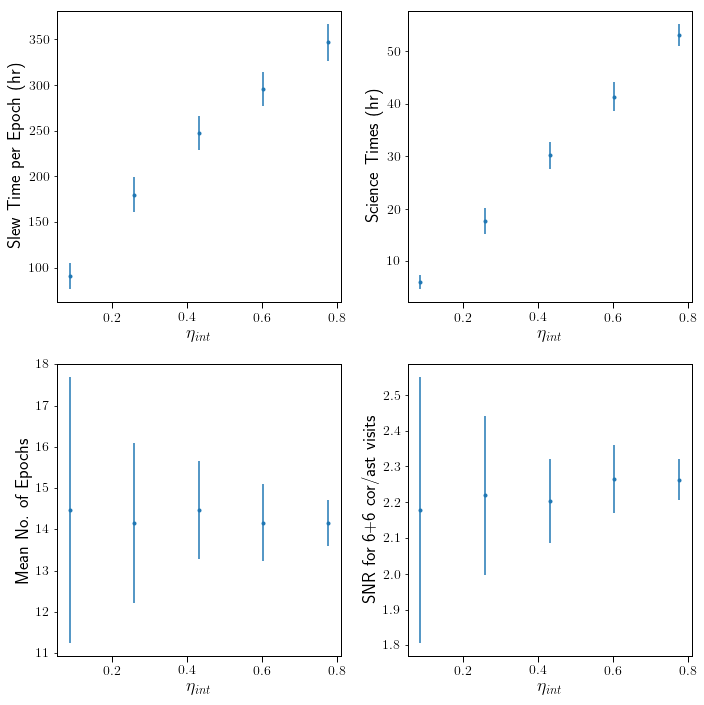

In [93]:
mean_times=np.array(mean_times)
std_times=np.array(std_times)
mean_science_times=np.array(mean_science_times)
std_science_times=np.array(std_science_times)
mean_Nepochs=np.array(mean_Nepochs)
std_Nepochs=np.array(std_Nepochs)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.errorbar(np.array(Ndraws[::2]).astype(float)/len(obj_names_all), mean_times, std_times, fmt='.')
plt.xlabel(r'$\eta_{int}$')
plt.ylabel('Slew Time per Epoch (hr)')

plt.subplot(222)
plt.errorbar(np.array(Ndraws[::2]).astype(float)/len(obj_names_all), mean_science_times, std_science_times, fmt='.')
plt.xlabel(r'$\eta_{int}$')
plt.ylabel('Science Times (hr)')

plt.subplot(223)
plt.errorbar(np.array(Ndraws[::2]).astype(float)/len(obj_names_all), 
             mean_Nepochs/np.array(Ndraws[::2]), 
             std_Nepochs/np.array(Ndraws[::2]), fmt='.')
plt.xlabel(r'$\eta_{int}$')
plt.ylabel('Mean No. of Epochs')

plt.subplot(224)
plt.errorbar(np.array(Ndraws[::2]).astype(float)/len(obj_names_all), 
             mean_snr/np.array(Ndraws[::2]), std_snr/np.array(Ndraws[::2]), fmt='.')
plt.xlabel(r'$\eta_{int}$')
plt.ylabel('SNR for 6+6 cor/ast visits')
plt.tight_layout()
plt.show()

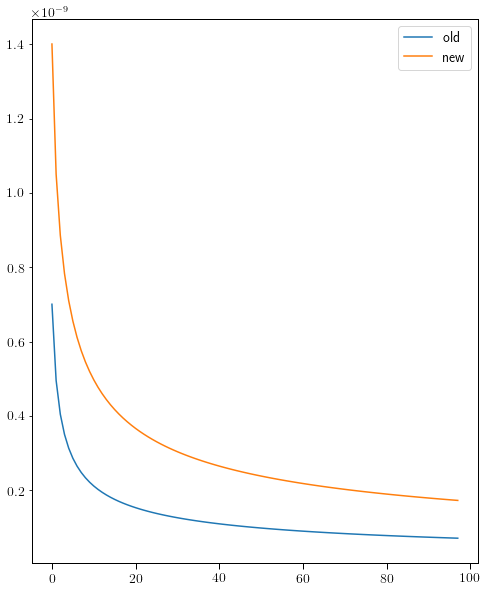

In [252]:
# rv to detect stellar jitter to predict how to space apart epochs/observations; multi-colour photometry

## Comparing different ways of computing PM error (basically standard deviation of slope)
plt.figure()
plt.plot(get_pm_error_old(sigmas_interesting[0], Nepochs=np.arange(2,100), dt=2.), label='old')
plt.plot(np.array([get_pm_error(sigmas_interesting[0], Nepochs=zz, t_tot=2.) for zz in np.arange(2,100)]), label='new')
plt.legend()

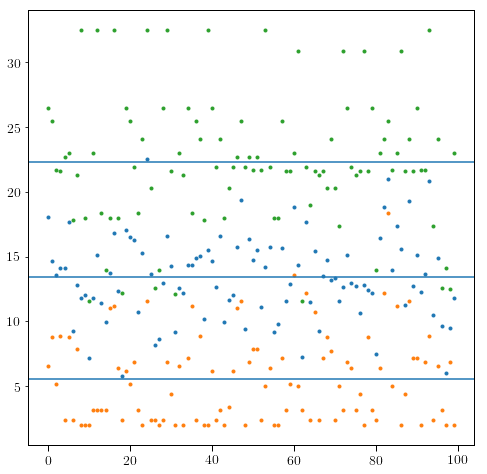

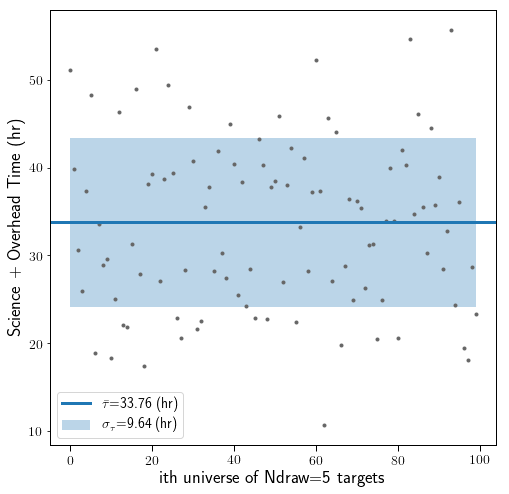

In [274]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(Nuniverse), np.nanmean(tot_Nepochs, axis=1), '.')
plt.plot(np.arange(Nuniverse), np.nanmin(tot_Nepochs, axis=1), '.')
plt.plot(np.arange(Nuniverse), np.nanmax(tot_Nepochs, axis=1), '.')
plt.axhline(np.nanmean(tot_Nepochs))
plt.axhline(np.nanmean(np.nanmin(tot_Nepochs, axis=1)))
plt.axhline(np.nanmean(np.nanmax(tot_Nepochs, axis=1)))


plt.figure(figsize=(8,8))
plt.plot(np.arange(Nuniverse), tot_times, '.', color='0.4')
plt.axhline(np.nanmedian(tot_times), lw=3, 
            label=r'$\bar \tau$={:.2f} (hr)'.format(np.nanmedian(tot_times)))
plt.fill_between(np.arange(Nuniverse), np.nanmedian(tot_times)-np.nanstd(tot_times),
                np.nanmedian(tot_times)+np.nanstd(tot_times), alpha=0.3,
                label=r'$\sigma_\tau$={:.2f} (hr)'.format(np.nanstd(tot_times)))
#plt.xlim((0, Nuniverse-1))
plt.xlabel('ith universe of Ndraw=5 targets')
plt.ylabel('Science + Overhead Time (hr)')
plt.legend()
plt.show()

(array([[2.9, 2. , 2.8, 2.6, 2. ]]), (1,))

### Astrometric precision ###

The astrometric (positional) precision is related to the angular resolution and SNR achieved.

$\sigma = \frac{\theta}{2\mathrm{SNR}} = \left(\frac{\lambda}{2D_{tel}}\right) \frac{1}{\sqrt{N_{obs}t_{exp}}} \frac{1}{\sqrt{F_0 10^{(-0.4m_*)} A_{tel} QE}}$

A
Star		 Mass	 d (pc)	 Wobble (uas)	 Nepochs ( 1.0 sig)	 PM_err (uas/yr)	 sys_err (uas)
----------------------------------------------------------------------------------------
HIP19335	1.3	8.07	0.1633		2.9		0.0021			0.1980
HIP57757	1.2	3.65	0.3259		2.0		0.0008			0.1932
HIP116085	0.7	10.93	0.1663		2.8		0.0030			0.1888
HIP48113	1.0	7.18	0.1750		2.6		0.0014			0.1846
HIP15371	1.0	10.54	0.2829		2.0		0.0014			0.1807
----------------------------------------------------------------------------------------
Total Obs Time = Avg Nepochs x (tot slew per epoch + tot exp per epoch) 
                = 0.29 d
----------------------------------------------------------------------------------------
VS. Total Obs Time = 2.70 d if 58 targets with epochs tacked onto orbits observations


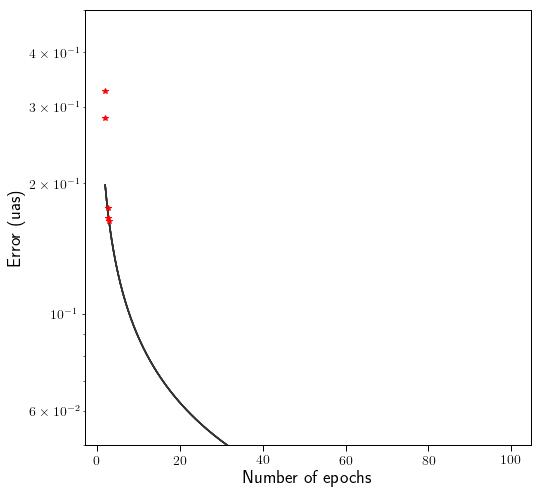

In [267]:
#d_interesting = np.array(result['Distance_distance'])
#print(stellar_distances[idraw], a_eeq)
mag_interesting = np.array(result['FLUX_V'])
#stellar_distances = stellar_distances*0. + 40.
wobble_interesting = get_astrometric_amplitude(mp[1], stellar_masses, a_eeq, stellar_distances[idraw])

plt.figure(figsize=(8,8))
f_equiv_interesting = get_equivalent_flux(mag_interesting, F0=F0, A_tel=area)
sigmas_interesting = get_astrometric_precision(f_equiv_interesting, t_exp, d_tel=dia)
Nepochs = np.arange(2, 100, 0.1)
epochs_needed = mag_interesting*0.0

sigma_d=1.
arch='A'
print(arch)
print("""Star\t\t Mass\t d (pc)\t Wobble (uas)\t Nepochs ( {:.1f} sig)\t PM_err (uas/yr)\t sys_err (uas)
----------------------------------------------------------------------------------------""".format(sigma_d))
for jj in range(len(sigmas_interesting)):
    pm_errors_interesting = np.array([get_pm_error(sigmas_interesting[jj], Nepochs=Ne, t_tot=2.) for Ne in Nepochs]) * 1e6
    sys_errors = sys_error[arch] / np.sqrt(Nepochs)
    tot_errors = np.sqrt(pm_errors_interesting**2 + sys_errors**2)
#Nepochs_interesting = get_Nepochs(wobble_interesting*1e-6, sigmas_interesting, dt=2.)
    plt.plot(Nepochs, pm_errors_interesting, label="{}".format(jj))
    plt.plot(Nepochs, sigma_d*tot_errors, '-', color='0.2')
    epochs_needed[jj] = Nepochs[np.argmin(abs(wobble_interesting[jj]-sigma_d*tot_errors))]

    print("{}\t{}\t{:.2f}\t{:.4f}\t\t{:.1f}\t\t{:.4f}\t\t\t{:.4f}".format(obj_names[jj], stellar_masses[jj], 
                                                                           stellar_distances[jj], wobble_interesting[jj],
                                                                                         epochs_needed[jj],
                                                                                        pm_errors_interesting[jj], sys_errors[jj]))
plt.plot(epochs_needed, wobble_interesting, "r*")
plt.yscale('log')
plt.ylabel('Error (uas)')
plt.xlabel('Number of epochs')
#plt.legend()
plt.ylim((0.05, .5))



# assuming 100s exposures per epoch, avg # of epochs needed, and total slew time per epoch,
# the total telescope time needed is roughly (settling time not accounted for)
tot_time = np.nanmean(epochs_needed) * (300./60.*5 + 144.41) / 60. / 24.
#tot_time_58 = np.nanmean(epochs_needed) * (300./60.*58 + 10.*58) / 60. / 24.
print("""----------------------------------------------------------------------------------------
Total Obs Time = Avg Nepochs x (tot slew per epoch + tot exp per epoch) 
                = {:.2f} d""".format(tot_time))
print("""----------------------------------------------------------------------------------------
VS. Total Obs Time = {:.2f} d if 58 targets with epochs tacked onto orbits observations""".format(tot_time_58+.134))

### Moving Forward ###
- This analytic calculation vs. simulation+recovery (what Eduardo Bendek & Mark M. did; more robust)
- Settling time + system architecture specs (engineer Q)? 
- Exposure time calculator (although won't make too much of difference in final answer 10s or 1000s)
- This calculation assumed centroiding error is the noise floor, rather than some other systematic error (e.g., availability of comparison stars for bright targets to do relative astrometry, optical distortions) (Mark P seemed to only account for this in his DRM, but how can we justify this...?) **The number of epochs from this noise floor is at odds with what Mark M. described** 
- The time estimated is a pretty conservative estimate, since in realistic mission setting we'd be optimizing per target time

In [246]:
## Compute total time if assume 12 epoch per target (as Bendek & Marley)
## Repeat analysis for many different random draws
## 3-sigma vs. 1-sigma uncertainty


array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

(array([21.315 , 11.1203, 16.8768, 18.9038, 12.0464]),
 array([5.5 , 3.6 , 6.74, 5.1 , 5.24], dtype=float32))

In [12]:
cities = np.random.RandomState(42).rand(70,2)
route = two_opt(cities, tol=0.001, closed=False)
#new_cities_order = np.concatenate((np.array([cities[route[i]] for i in range(len(route))]),np.array([cities[0]])))


In [13]:
route

array([ 0, 69, 53, 12, 68,  4, 57, 27, 60, 63, 26, 56, 17, 25, 40, 59, 44,
       67, 52,  6, 58, 38, 35, 31, 47, 46, 43, 37,  1, 19, 48,  9, 30, 42,
       11, 51, 23,  8, 32, 22, 45, 33, 16, 34,  5, 21,  3, 36, 50, 64, 20,
       13, 62, 66, 29,  7, 55, 61, 39, 65, 24, 15, 10, 14, 41, 18, 54,  2,
       28, 49])

In [34]:
timeit path_distance_lam(route, cities)

The slowest run took 5.33 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 423 µs per loop


In [35]:
timeit path_distance_fn(route, cities)

The slowest run took 8.52 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 398 µs per loop


In [40]:
np.linalg.norm?